# Housing Sale Price Prediction Program
- Load Libraires and Data
- Data Cleaning and Visualization
- Modelling
- Prediction

### Load Libraries and Data
1. Libraries: (1) data structure; (2) visualization; (3) modelling
2. Data: (1) ZExercise Training; (2) ZExercise Testing; (3) (public data) Census Bureau Shapefiles for Washington States

In [1]:
# data structure
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
import geopandas as gpd
from math import e
import esda
import libpysal as lps

# visualization
import matplotlib.pyplot as plt 
import seaborn as sb
from pprint import pprint 

# modelling
from sklearn import linear_model
from sklearn.model_selection import train_test_split # data split
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.metrics import mean_absolute_error

In [ ]:
df_train = pd.read_csv("T.csv")
df_test = pd.read_csv("C.csv")

In [ ]:
# shapefile of Washington state from US Census Bureau
WA_shp = gpd.read_file('tl_2015_53_bg.shp')
# create a custom polygon for our data area
polygon = Polygon([(-122.6,47.13), (-122.6, 47.9), (-121.1, 47.9), (-121.1, 47.13), (-122.6, 47.13)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4269")
# clip the shapefile
WA_clipped = WA_shp.clip(polygon)

### Data Cleaning and Visualization

In [4]:
# Sale Price: create a log value to see which one fits better
df_train['ln_Sale']=np.log(df_train['SaleDollarCnt'])

# Impute or compliment missing values
# 1. Garage: replace missing with 0, and create a new dummy "garage" to indicate
# 2. View: convert to dummies, including missing
# 3. BG-level missing values: K-nearest neighboring BG
# 4. Zoning codes: convert to dummies
# 5. TransDate: using "week of the year"
df_train['Garage'] = 0
df_train.loc[df_train['GarageSquareFeet'].isnull()==False,'Garage']=1
df_train.loc[df_train['Garage']==0,'GarageSquareFeet']=0
df_train=df_train.join(pd.get_dummies(df_train['ViewType'],dummy_na=True,prefix='view'))
imputer = KNNImputer(n_neighbors=100)
imputed = imputer.fit_transform(df_train[['BGMedHomeValue','BGMedRent',
                                          'BGMedYearBuilt','Longitude','Latitude']])
df_train[['BGMedHomeValue','BGMedRent','BGMedYearBuilt','Longitude','Latitude']]=imputed
df_train=df_train.join(pd.get_dummies(df_train['ZoneCodeCounty'],dummy_na=True,prefix='zoning'))
df_train['date'] = pd.to_datetime(df_train['TransDate'])
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week
df_train['week_of_year']=df_train['week_of_year'].astype('int32')

WA_clipped has 2205 unique block groups
Spatially joint df_train has 1283 unique block groups


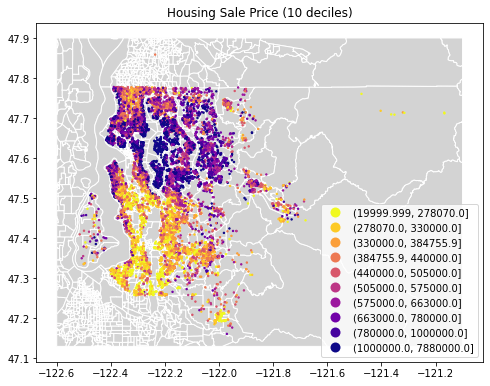

In [5]:
# geo-processing
# turning df into geo_df
df_train['lon'],df_train['lat']=df_train['Longitude']/(10**6),df_train['Latitude']/(10**6)
geometry=[Point(xy) for xy in zip(df_train['lon'],df_train['lat'])]
geo_df_train = gpd.GeoDataFrame(df_train, crs="EPSG:4269",geometry=geometry)
# spatial join: block group level
geo_df_train_bg = geo_df_train.sjoin(WA_clipped[['GEOID','COUNTYFP','BLKGRPCE','INTPTLAT','INTPTLON',
                                                 'ALAND','AWATER','geometry']],how="left")
print("WA_clipped has",len(WA_clipped['GEOID'].unique()),"unique block groups")
print("Spatially joint df_train has",len(geo_df_train_bg['GEOID'].unique()),"unique block groups")
df_train = df_train.join(geo_df_train_bg[['GEOID','ALAND','AWATER']])
df_train = df_train.join(pd.get_dummies(df_train['GEOID'],dummy_na=True,prefix='bg_id'))
# Visualization: housing prices (10 quantiles)
geo_df_train['SaleDollarCnt_qt']=pd.qcut(geo_df_train['SaleDollarCnt'],10)
fig,ax = plt.subplots(figsize =(8,8))
WA_clipped.plot(ax=ax, **{'edgecolor':'white', 'facecolor':'lightgrey'})
cm = plt.cm.get_cmap('plasma').reversed()
geo_df_train.plot(ax=ax, markersize=2, column='SaleDollarCnt_qt',cmap=cm,legend=True)
plt.title('Housing Sale Price (10 deciles)')
plt.savefig('SaleDollarCnt-10qt.png')

Text(0.5, 1.0, 'GarageSquareFeet')

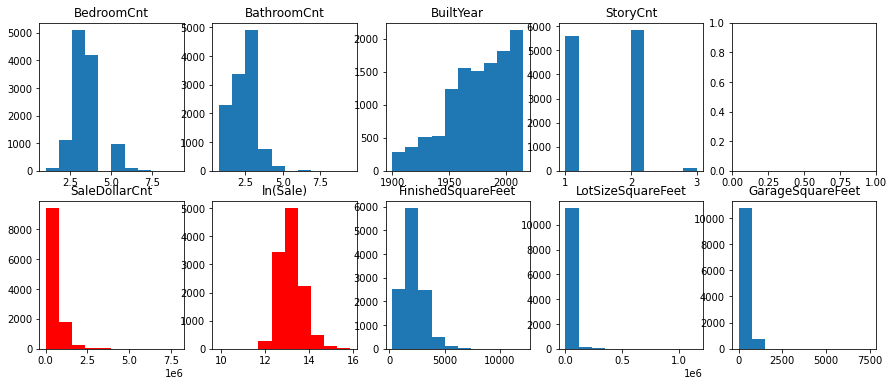

In [6]:
# Histogram: housing characteristics, sale price (nominal, log)
fig, axs = plt.subplots(2,5,figsize=(15, 6))
axs[0,0].hist(df_train['BedroomCnt'])
axs[0,1].hist(df_train['BathroomCnt'])
axs[0,2].hist(df_train['BuiltYear'])
axs[0,3].hist(df_train['StoryCnt'])
axs[1,0].hist(df_train['SaleDollarCnt'],color='red')
axs[1,1].hist(df_train['ln_Sale'],color='red')
axs[1,2].hist(df_train['FinishedSquareFeet'])
axs[1,3].hist(df_train['LotSizeSquareFeet'])
axs[1,4].hist(df_train['GarageSquareFeet'])
axs[0,0].set_title('BedroomCnt')
axs[0,1].set_title('BathroomCnt')
axs[0,2].set_title('BuiltYear')
axs[0,3].set_title('StoryCnt')
axs[1,0].set_title('SaleDollarCnt')
axs[1,1].set_title('ln(Sale)')
axs[1,2].set_title('FinishedSquareFeet')
axs[1,3].set_title('LotSizeSquareFeet')
axs[1,4].set_title('GarageSquareFeet')

Text(0.5, 1.0, 'Average ln(Sale Price) as all "week of the year"')

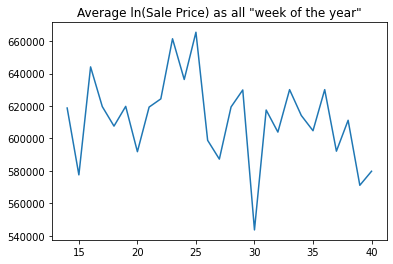

In [7]:
# Visualization: is there obvious time trend on sale price?
df_date_mean_ln_Sale = df_train.groupby(['week_of_year'])['SaleDollarCnt'].agg(['mean'])
plt.plot(df_date_mean_ln_Sale.index, df_date_mean_ln_Sale['mean'])
plt.title('Average ln(Sale Price) as all "week of the year"')

Text(0.5, 1.0, 'GarageSquareFeet')

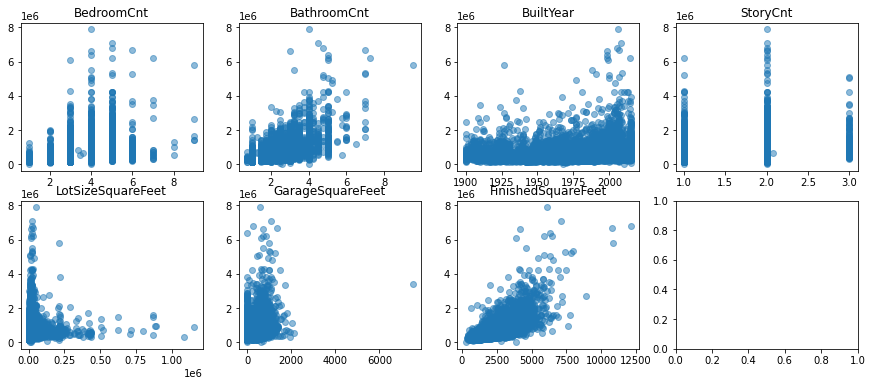

In [8]:
# scatter plot
fig, axs = plt.subplots(2,4,figsize=(15, 6))
axs[0,0].scatter(df_train['BedroomCnt'],df_train['SaleDollarCnt'],alpha=0.5)
axs[0,1].scatter(df_train['BathroomCnt'],df_train['SaleDollarCnt'],alpha=0.5)
axs[0,2].scatter(df_train['BuiltYear'],df_train['SaleDollarCnt'],alpha=0.5)
axs[0,3].scatter(df_train['StoryCnt'],df_train['SaleDollarCnt'],alpha=0.5)
axs[1,2].scatter(df_train['FinishedSquareFeet'],df_train['SaleDollarCnt'],alpha=0.5)
axs[1,0].scatter(df_train['LotSizeSquareFeet'],df_train['SaleDollarCnt'],alpha=0.5)
axs[1,1].scatter(df_train['GarageSquareFeet'],df_train['SaleDollarCnt'],alpha=0.5)
axs[0,0].set_title('BedroomCnt')
axs[0,1].set_title('BathroomCnt')
axs[0,2].set_title('BuiltYear')
axs[0,3].set_title('StoryCnt')
axs[1,2].set_title('FinishedSquareFeet')
axs[1,0].set_title('LotSizeSquareFeet')
axs[1,1].set_title('GarageSquareFeet')

Text(0.5, 1.0, 'BGMedAge-ln(Sale)')

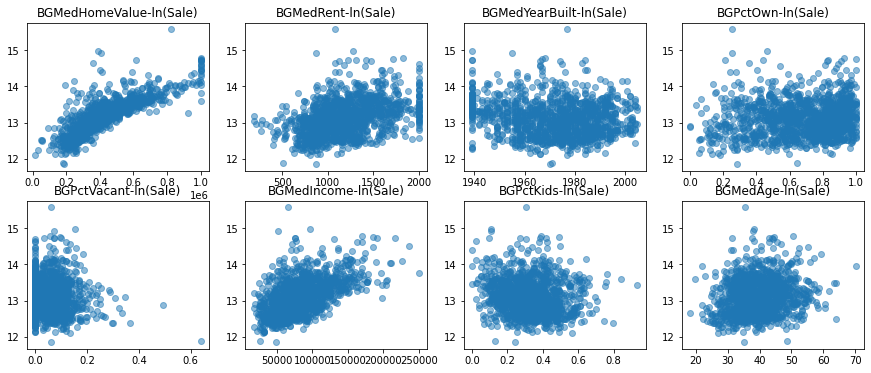

In [9]:
# BG level visualization
df_bg = geo_df_train_bg.groupby(['GEOID'])[['ln_Sale','BGMedHomeValue','BGMedRent','BGMedYearBuilt','BGPctOwn',
                                            'BGPctVacant', 'BGMedIncome', 'BGPctKids', 'BGMedAge']].agg(['mean'])
fig, axs = plt.subplots(2,4,figsize=(15, 6))
axs[0,0].scatter(df_bg['BGMedHomeValue'],df_bg['ln_Sale'],alpha=0.5)
axs[0,1].scatter(df_bg['BGMedRent'],df_bg['ln_Sale'],alpha=0.5)
axs[0,2].scatter(df_bg['BGMedYearBuilt'],df_bg['ln_Sale'],alpha=0.5)
axs[0,3].scatter(df_bg['BGPctOwn'],df_bg['ln_Sale'],alpha=0.5)
axs[1,0].scatter(df_bg['BGPctVacant'],df_bg['ln_Sale'],alpha=0.5)
axs[1,1].scatter(df_bg['BGMedIncome'],df_bg['ln_Sale'],alpha=0.5)
axs[1,2].scatter(df_bg['BGPctKids'],df_bg['ln_Sale'],alpha=0.5)
axs[1,3].scatter(df_bg['BGMedAge'],df_bg['ln_Sale'],alpha=0.5)
axs[0,0].set_title('BGMedHomeValue-ln(Sale)')
axs[0,1].set_title('BGMedRent-ln(Sale)')
axs[0,2].set_title('BGMedYearBuilt-ln(Sale)')
axs[0,3].set_title('BGPctOwn-ln(Sale)')
axs[1,0].set_title('BGPctVacant-ln(Sale)')
axs[1,1].set_title('BGMedIncome-ln(Sale)')
axs[1,2].set_title('BGPctKids-ln(Sale)')
axs[1,3].set_title('BGMedAge-ln(Sale)')
# discontinuity at BGMedHomeValue==10**6, BGMedRent==1250, BGMedRent==2000, BGMedYearBuilt==1940, BGPctVacant = 0

### Modelling
1. Data Preparation: pre-processing
2. Linear models: OLS, Lasso, Ridge, EN
3. Non-parametric: Random Forest Regression, Gradiant Boosting Machine

In [10]:
# prepare y variables
y1 = ['SaleDollarCnt']
y2 = ['ln_Sale']

# prepare X variables
X1 = ['BedroomCnt', 'BathroomCnt', 'StoryCnt', 'BuiltYear','Latitude','Longitude',
          'FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet', # Home Characteristics
            'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt',
            'BGPctOwn', 'BGPctVacant', 'BGMedIncome', 'ALAND','AWATER',
            'BGPctKids', 'BGMedAge'] # BG Characteristics

# dummies
X2 = ['Garage','view_78.0', 'view_79.0', 'view_82.0', 'view_241.0',
            'view_244.0', 'view_246.0', 'view_247.0']

# zoning dummies
cls = df_train.columns.tolist()
X_zoning=[]
for i in cls:
    if i[0:6]=='zoning':
        X_zoning.append(i)
X_zoning.remove('zoning_nan')
# bg dummies
X_bg_id=[]
for i in cls:
    if i[0:5]=='bg_id':
        X_bg_id.append(i)

# polynomials
polyset = ['FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet']
X3=[]
for i in polyset:
    for j in range(2,6):
        st = i + "_" + str(j)
        st_std = st+"std"
        df_train[st]=df_train[i]**j
        df_train[st_std]=( df_train[st]-df_train[st].mean() )/df_train[st].std()
        X3.append(st_std)

# discontinuity
#BGMedHomeValue==10**6, BGMedRent==1250, BGMedRent==2000, BGMedYearBuilt==1940, BGPctVacant = 0
df_train['BGMedHomeValue10e6']=0
df_train.loc[df_train['BGMedHomeValue']==10**6,'BGMedHomeValue10e6']=1
df_train['BGMedRent1250']=0
df_train.loc[df_train['BGMedRent']==1250,'BGMedRent1250']=1
df_train['BGMedRent2000']=0
df_train.loc[df_train['BGMedRent']==2000,'BGMedRent2000']=1
df_train['BGMedYearBuilt1940']=0
df_train.loc[df_train['BGMedYearBuilt']==1940,'BGMedYearBuilt1940']=1
df_train['BGPctVacant0']=0
df_train.loc[df_train['BGPctVacant']==0,'BGPctVacant0']=1
X4=['BGMedHomeValue10e6','BGMedRent1250','BGMedRent2000','BGMedYearBuilt1940','BGPctVacant0']

# interaction
ita_set = ['BedroomCnt','BathroomCnt', 'StoryCnt', 'BuiltYear','FinishedSquareFeet','LotSizeSquareFeet',
           'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt','BGPctOwn','BGPctKids','BGMedAge']
X5=[]
empty_list = [0]*11588
df_ita = pd.DataFrame(empty_list, columns=['0'])
for i in range(len(ita_set)):
    for j in range(i+1,len(ita_set)):
        if i!=j:
            st = ita_set[i] + "X" + ita_set[j]
            st_std = st+"std"
            df_temp = df_train[ita_set[i]]*df_train[ita_set[j]]
            df_tempstd=(df_temp-df_temp.mean())/df_temp.std()
            df_ita=df_ita.join(df_tempstd.to_frame(name=st_std))
            X5.append(st_std)
df_ita=df_ita.drop(['0'], axis=1)
df_train=df_train.join(df_ita)

# spatial lags
df_sl=pd.read_csv('df_sl.csv')
df_train=df_train.join(df_sl)
X6 = df_sl.columns.values[1:].tolist()

# time: week of the year
X7=['week_of_year']

# # constant term for intercept
# df_train['const']=1

In [11]:
# standardize all non-dummy variables in X1
X1_df = df_train[X1]
std_X1_df=(X1_df-X1_df.mean())/X1_df.std()
# rename variable names
names,names_std=std_X1_df.columns,[]
for i in range(len(names)):
    names_std.append(names[i]+'_std')
std_X1_df.set_axis(names_std, axis=1, inplace=True)

In [12]:
model_df = df_train[y1+y2+X2+X3+X4+X5+X6+X7+X_zoning+X_bg_id].join(std_X1_df)
X_var = model_df.drop(y1+y2,axis=1)
y_var1,y_var2 = model_df[y1],model_df[y2]

y1 - SaleDollarCnt

In [13]:
# trainX,testX,trainy1,testy1=train_test_split(X_var,y_var1,test_size=0.3,random_state=42)

In [14]:
# # Modelling - OLS, Lasso, Ridge, Elastic Net
# ols=LinearRegression().fit(trainX, trainy1)
# lasso = linear_model.LassoCV(max_iter=1000,random_state=42).fit(trainX, trainy1.values.ravel())
# ridge = linear_model.RidgeCV(alphas=[0.01,0.1,1,2,5,10,100]).fit(trainX, trainy1.values.ravel())
# elasticnet = linear_model.ElasticNetCV(l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99,1],
#                                       max_iter=1000,random_state=42).fit(trainX, trainy1.values.ravel())

In [15]:
# # Error Comparison
# print('ols',ols.score(testX,testy1))
# print('lasso',lasso.score(testX,testy1))
# print('ridge',ridge.score(testX,testy1))
# print('elastic net',elasticnet.score(testX,testy1)) # same result as LASSO

# error_ols = abs(ols.predict(testX)-testy1.values.ravel())/testy1.values.ravel()
# print("OLS error mean:",error_ols.mean(),"; error median:",np.median(error_ols))
# error_lasso = abs(lasso.predict(testX)-testy1.values.ravel())/testy1.values.ravel()
# print("Lasso error mean:",error_lasso.mean(),"; error median:",np.median(error_lasso))
# error_ridge = abs(ridge.predict(testX)-testy1.values.ravel())/testy1.values.ravel()
# print("Ridge error mean:",error_ridge.mean(),"; error median:",np.median(error_ridge))

y2 - ln(Sale)

In [16]:
trainX,testX,trainy2,testy2=train_test_split(X_var,y_var2,test_size=0.3,random_state=42)

In [13]:
# Modelling - OLS, Lasso, Ridge, Elastic Net
# ols = LinearRegression().fit(trainX, trainy2)
lasso = linear_model.LassoCV(max_iter=10000,random_state=42).fit(trainX, trainy2.values.ravel())
ridge = linear_model.RidgeCV(alphas=[0.01,0.1,1,2,5,10,100]).fit(trainX, trainy2.values.ravel())
elasticnet = linear_model.ElasticNetCV(l1_ratio=[.1,.25,.5,.75,.9,.95,.99,1],
                                      max_iter=10000,random_state=42).fit(trainX, trainy2.values.ravel())

In [14]:
# Error Comparison
# print('ols',ols.score(testX,testy2))
print('lasso',lasso.score(testX,testy2))
print('ridge',ridge.score(testX,testy2))
print('elastic net',elasticnet.score(testX,testy2)) # same result as LASSO

from math import e
error_lasso = abs(e**lasso.predict(testX)-e**testy2.values.ravel())/e**testy2.values.ravel()
print("Lasso error mean:",error_lasso.mean(),"; error median:",np.median(error_lasso))
error_ridge = abs(e**ridge.predict(testX)-e**testy2.values.ravel())/e**testy2.values.ravel()
print("Ridge error mean:",error_ridge.mean(),"; error median:",np.median(error_ridge))

lasso 0.9140203372089035
ridge 0.9136449128631136
elastic net 0.9139673522387591
Lasso error mean: 0.11400161969662394 ; error median: 0.08353388939477577
Ridge error mean: 0.11441157647363898 ; error median: 0.08320619765746405


In [17]:
# best of linear models: Ridge 8.3%

### Non-parametric (1): Random Forest Regression
- hyperparameter tuning
- model training and testing with the best params
- rank and list 30 most important features

In [18]:
# Hyper-parameter Tuning (random search and grid search, through cross-validation)
n_estimators = [100, 500, 1000, 2000] # Number of trees in random forest
max_features = ['auto','sqrt'] # Number of features to consider at every split
max_depth = [5,10,20,None] # Maximum number of levels in tree
min_samples_split = [5,10] # Minimum number of samples required to split a node
min_samples_leaf = [1,2,4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}  # Create the random grid
pprint(random_grid)

{'bootstrap': [False],
 'max_depth': [None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [2],
 'min_samples_split': [5],
 'n_estimators': [1000]}


In [19]:
# trainX,testX,trainy1,testy1=train_test_split(X_var,y_var1,test_size=0.3,random_state=42)

In [20]:
# rf = RandomForestRegressor() # First create the base model to tune
# rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# rf_random.fit(trainX, trainy1.values.ravel())
# rf_random.best_params_

In [21]:
trainX,testX,trainy2,testy2=train_test_split(X_var,y_var2,test_size=0.3,random_state=42)

In [22]:
rf = RandomForestRegressor() # First create the base model to tune
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(trainX, trainy2.values.ravel())
rf_random.best_params_
# {'bootstrap': False,
#  'max_depth': None,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 5,
#  'n_estimators': 1000}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [23]:
# testing: predict values in testing set
Y_pred = rf_random.predict(testX)
from math import e
rf_error = abs(e**Y_pred - e**testy2.values.ravel())/e**testy2.values.ravel()
print('random forest median error - log model', np.median(rf_error))

random forest median error - log model 0.080445329085747


In [24]:
# Forest Importance: understanding the meaning of the model
rf_model = RandomForestRegressor(bootstrap=False, max_depth=None,max_features='sqrt',min_samples_leaf=2,
                                 min_samples_split=5,n_estimators=1000) # using the best parameters
rf_model.fit(trainX, trainy2.values.ravel()) # fit the model
importances = rf_model.feature_importances_ # get forest importance
feature_names = [f"feature {i}" for i in range(X_var.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
IPT=[]
for i in range(len(forest_importances)):
    ipt = [forest_importances[i],i,X_var.columns.tolist()[i]]
    IPT.append(ipt)
IPT=sorted(IPT)
IPT[-30:]

[[0.013682838389633998, 77, 'BGMedHomeValueXBGMedYearBuiltstd'],
 [0.013903428369419194, 65, 'FinishedSquareFeetXBGMedRentstd'],
 [0.014719339493475616, 66, 'FinishedSquareFeetXBGMedYearBuiltstd'],
 [0.015090803345217521, 11, 'FinishedSquareFeet_5std'],
 [0.015288464069840677, 57, 'BuiltYearXBGMedHomeValuestd'],
 [0.015454207918444679, 55, 'BuiltYearXFinishedSquareFeetstd'],
 [0.015588123898531607, 1710, 'FinishedSquareFeet_std'],
 [0.015712315775491353, 224, 'SaleDollarCnt_sl400'],
 [0.015955602915200255, 216, 'BGMedHomeValue_sl200'],
 [0.015980971197771417, 208, 'ln_Sale_sl200'],
 [0.016696375570422226, 9, 'FinishedSquareFeet_3std'],
 [0.016793536666455666, 8, 'FinishedSquareFeet_2std'],
 [0.017181101704148376, 225, 'ln_Sale_sl400'],
 [0.01763976308263841, 182, 'BGMedHomeValue_sl50'],
 [0.01777719701773617, 10, 'FinishedSquareFeet_4std'],
 [0.017817289148166368, 148, 'BGMedHomeValue_sl10'],
 [0.017867879305026486, 30, 'BedroomCntXBGMedHomeValuestd'],
 [0.018488716356844268, 207, 'Sal

### Non-parametric (2): Gradiant Boosting Machine
- hyperparameter tuning
- model training and testing with the best params

In [31]:
trainX,testX,trainy2,testy2=train_test_split(X_var,y_var2,test_size=0.3,random_state=42)

In [47]:
# Hyperparameter Tuning
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 3)] # Number of trees in random forest
max_depth = [5,10,None] # Maximum number of levels in tree
min_samples_split = [1,2,5] # Minimum number of samples required to split a node
min_samples_leaf = [1,2,4] # Minimum number of samples required at each leaf node
loss = ["squared_error"]
learning_rate = [1,0.1,0.05,0.01]
random_gd = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'loss': loss,
               'learning_rate': learning_rate}  # Create the random grid
pprint(random_gd)

{'learning_rate': [1, 0.1, 0.05, 0.01],
 'loss': ['squared_error'],
 'max_depth': [5, 10, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [1, 2, 5],
 'n_estimators': [200, 500, 800]}


In [ ]:
gbm = ensemble.GradientBoostingRegressor() # First create the base model to tune
# gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
from sklearn.model_selection import GridSearchCV
gbm_random = GridSearchCV(estimator = gbm, param_grid = random_gd, 
                               cv = 3, verbose=2, n_jobs = -1)
gbm_random.fit(trainX, trainy2.values.ravel())

In [43]:
gbm_random.best_params_

{'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

In [32]:
# train the data again with the best params
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "learning_rate": 0.05,
    "loss": "squared_error",
}
gbm = ensemble.GradientBoostingRegressor(**params)
gbm.fit(trainX, trainy2.values.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=500)

In [33]:
Y_pred = gbm.predict(testX)
from math import e
gbm_error = abs(e**Y_pred - e**testy2.values.ravel())/e**testy2.values.ravel()
print('GBM median error - log model', np.median(gbm_error))

GBM median error - log model 0.07828659221797772


# Prediction - best model: GBM
- Step 1: Check all variables except sale price between two files
- Step 2: Preprocess everything in the same way
- Step 3: Assign the whole "Training_Confidencial1.csv" as training set, train the GBM
- Step 4: use the GBM to predict for "Testing_confidencial2.csv"
- Step 5: make some visualization to see if the prediction makes sense

### Step 1: Check all variables except sale price between two files
#### (1) Load Data
#### (2) Compare: most variables are in similar range, except Transaction Date
- Transaction dates in training: April to September
- Transaction dates in testing: October to December

In [2]:
df_train = pd.read_csv("Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv")
df_test = pd.read_csv("Data Science ZExercise_TEST_CONFIDENTIAL2.csv")
new_index = np.array(list(range(11588,15990)))
df_test.set_index(new_index,inplace=True)
df_combine = df_train.append(df_test)

In [3]:
df_combine.index # check if the combined file is indexed correctly

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            15980, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988,
            15989],
           dtype='int64', length=15990)

In [4]:
df_train.describe()

,PropertyID,SaleDollarCnt,censusblockgroup,Usecode,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,...,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
count,1.158800e+04,1.158800e+04,1.158800e+04,11588.0,11588.000000,11588.000000,11588.000000,8747.000000,1.158800e+04,11588.000000,...,1.158800e+04,1.158800e+04,1.158200e+04,8957.000000,11341.000000,11588.000000,11588.000000,11588.000000,11588.000000,11588.000000
mean,5.502866e+07,6.137157e+05,5.300000e+11,9.0,3.451800,2.327628,2199.899249,490.981022,1.601437e+04,1.528571,...,4.755070e+07,-1.221995e+08,4.337194e+05,1235.541699,1973.356406,0.747764,0.050873,94859.222817,0.360058,39.772886
std,1.605832e+07,4.577593e+05,0.000000e+00,0.0,0.865682,0.872601,936.877939,220.434500,4.324446e+04,0.521864,...,1.424218e+05,1.417068e+05,1.781283e+05,394.371247,17.786514,0.196277,0.058676,36285.661949,0.140494,6.726432
min,4.864894e+07,2.000000e+04,5.300000e+11,9.0,1.000000,0.750000,270.000000,10.000000,1.034000e+03,1.000000,...,4.716120e+07,-1.225150e+08,1.480000e+04,185.000000,1939.000000,0.000000,0.000000,17500.000000,0.000000,18.200000
25%,4.880374e+07,3.550000e+05,5.300000e+11,9.0,3.000000,1.750000,1530.000000,380.000000,5.683750e+03,1.000000,...,4.744830e+07,-1.223147e+08,3.020000e+05,933.000000,1960.000000,0.618700,0.000000,69167.000000,0.260700,35.000000
50%,4.895489e+07,5.050000e+05,5.300000e+11,9.0,3.000000,2.500000,2060.000000,476.000000,7.886500e+03,2.000000,...,4.756348e+07,-1.222056e+08,3.969000e+05,1173.000000,1975.000000,0.802200,0.038900,90455.000000,0.352600,39.400000
75%,4.910697e+07,7.150000e+05,5.300000e+11,9.0,4.000000,3.000000,2700.000000,600.000000,1.111100e+04,2.000000,...,4.767496e+07,-1.221112e+08,5.256000e+05,1508.000000,1987.000000,0.903800,0.080800,114306.000000,0.444200,43.800000
max,1.244354e+08,7.880000e+06,5.300000e+11,9.0,9.000000,9.500000,12130.000000,7504.000000,1.157824e+06,3.000000,...,4.785848e+07,-1.211670e+08,1.000001e+06,2001.000000,2005.000000,1.000000,0.638400,250001.000000,0.934100,70.200000


In [5]:
df_test.describe()

,PropertyID,SaleDollarCnt,censusblockgroup,Usecode,BedroomCnt,BathroomCnt,FinishedSquareFeet,GarageSquareFeet,LotSizeSquareFeet,StoryCnt,...,Latitude,Longitude,BGMedHomeValue,BGMedRent,BGMedYearBuilt,BGPctOwn,BGPctVacant,BGMedIncome,BGPctKids,BGMedAge
count,4.402000e+03,0.0,4.402000e+03,4402.0,4402.000000,4402.000000,4402.000000,3264.000000,4402.000000,4402.000000,...,4.402000e+03,4.402000e+03,4.395000e+03,3439.000000,4340.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000
mean,5.348500e+07,NaN,5.300000e+11,9.0,3.454566,2.446691,2173.819173,490.670956,16184.919582,1.493063,...,4.755094e+07,-1.222070e+08,4.271300e+05,1220.081419,1972.481797,0.743355,0.051515,93290.642208,0.354692,39.922490
std,1.363566e+07,NaN,0.000000e+00,0.0,0.889844,0.979458,942.875187,208.831923,43018.883822,0.524333,...,1.450821e+05,1.412666e+05,1.769664e+05,390.600650,17.529664,0.197488,0.060073,36135.935800,0.138307,6.711337
min,4.864910e+07,NaN,5.300000e+11,9.0,1.000000,1.000000,450.000000,20.000000,1014.000000,1.000000,...,4.717648e+07,-1.225023e+08,4.900000e+04,185.000000,1939.000000,0.000000,0.000000,6917.000000,0.000000,18.200000
25%,4.880002e+07,NaN,5.300000e+11,9.0,3.000000,2.000000,1510.000000,378.250000,6000.000000,1.000000,...,4.744686e+07,-1.223202e+08,2.951000e+05,919.500000,1960.000000,0.614600,0.000000,67500.000000,0.259900,35.225000
50%,4.894242e+07,NaN,5.300000e+11,9.0,3.000000,2.500000,2020.000000,480.000000,8050.000000,1.000000,...,4.756262e+07,-1.222142e+08,3.894000e+05,1165.000000,1974.000000,0.795000,0.039100,89005.000000,0.346200,39.400000
75%,4.909140e+07,NaN,5.300000e+11,9.0,4.000000,3.000000,2640.000000,590.000000,11250.000000,2.000000,...,4.767939e+07,-1.221246e+08,5.108000e+05,1469.000000,1986.000000,0.897800,0.082900,113229.000000,0.434300,44.100000
max,1.244396e+08,NaN,5.300000e+11,9.0,12.000000,9.000000,8000.000000,2060.000000,956578.000000,3.000000,...,4.777759e+07,-1.211718e+08,1.000001e+06,2001.000000,2005.000000,1.000000,0.638400,250001.000000,0.934100,70.200000


In [6]:
# shapefile of Washington state from US Census Bureau
WA_shp = gpd.read_file('tl_2015_53_bg.shp')
# create a custom polygon for our data area
polygon = Polygon([(-122.6,47.13), (-122.6, 47.9), (-121.1, 47.9), (-121.1, 47.13), (-122.6, 47.13)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4269")
# clip the shapefile
WA_clipped = gpd.clip(WA_shp, polygon)

### Step 2: Preprocess everything in the same way

In [7]:
# Sale Price: create a log value
df_combine['ln_Sale']=np.log(df_combine['SaleDollarCnt'])

# Impute or compliment missing values
# 1. Garage: replace missing with 0, and create a new dummy "garage" to indicate
# 2. View: convert to dummies, including missing
# 3. BG-level missing values: K-nearest neighboring BG
# 4. Zoning codes: convert to dummies
# 5. TransDate: using "week of the year"
df_combine['Garage'] = 0
df_combine.loc[df_combine['GarageSquareFeet'].isnull()==False,'Garage']=1
df_combine.loc[df_combine['Garage']==0,'GarageSquareFeet']=0
df_combine=df_combine.join(pd.get_dummies(df_combine['ViewType'],dummy_na=True,prefix='view'))
imputer = KNNImputer(n_neighbors=100)
imputed = imputer.fit_transform(df_combine[['ln_Sale','SaleDollarCnt','BGMedHomeValue','BGMedRent',
                                          'BGMedYearBuilt','Longitude','Latitude']])
df_combine[['ln_Sale','SaleDollarCnt','BGMedHomeValue','BGMedRent','BGMedYearBuilt','Longitude','Latitude']]=imputed
df_combine=df_combine.join(pd.get_dummies(df_combine['ZoneCodeCounty'],dummy_na=True,prefix='zoning'))
df_combine['date'] = pd.to_datetime(df_combine['TransDate'])
df_combine['week_of_year'] = df_combine['date'].dt.isocalendar().week
df_combine['week_of_year'] = df_combine['week_of_year'].astype('int32')

In [9]:
# geo-processing
# turning df into geo_df
df_combine['lon'],df_combine['lat']=df_combine['Longitude']/(10**6),df_combine['Latitude']/(10**6)
geometry=[Point(xy) for xy in zip(df_combine['lon'],df_combine['lat'])]
geo_df_combine = gpd.GeoDataFrame(df_combine, crs="EPSG:4269",geometry=geometry)
# spatial join: block group level
geo_df_combine_bg = gpd.sjoin(geo_df_combine,WA_clipped[['GEOID','ALAND','AWATER',
                                                         'geometry']],how='left')
print("WA_clipped has",len(WA_clipped['GEOID'].unique()),"unique block groups")
print("Spatially joint df_combine has",len(geo_df_combine_bg['GEOID'].unique()),"unique block groups")
geo_bg_id = geo_df_combine_bg[['GEOID','ALAND','AWATER']]
geo_bg_dummies = pd.get_dummies(geo_bg_id['GEOID'],prefix='bg_id')
geo_bg = geo_bg_dummies.join(geo_bg_id[['ALAND','AWATER']])
df_combine = df_combine.join(geo_bg)

WA_clipped has 2205 unique block groups
Spatially joint df_combine has 1304 unique block groups


In [10]:
# create spatial lags for other variables
n_neighbor = [10,25,50,100,200,400] # number of neighboring houses considered as spatial lags
n_sum1,n_sum2=[],[]
for i in range(len(n_neighbor)):
    n = n_neighbor[i]
    w_knn = lps.weights.KNN.from_dataframe(geo_df_combine_bg,k=n)
    # (1) non-dummies
    X1 = ['SaleDollarCnt','ln_Sale', 'BedroomCnt', 'BathroomCnt', 'StoryCnt', 'BuiltYear', 
          'FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet', # Home Characteristics
          'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt',
          'BGPctOwn', 'BGPctVacant', 'BGMedIncome','BGPctKids', 'BGMedAge'] # BG Characteristics
    nearby1_sum = lps.weights.lag_spatial(w_knn, geo_df_combine_bg[X1])
    n_sum1.append(nearby1_sum)
    if i==0:
        nearby1_diff_avr = nearby1_sum/n
        for j in range(len(X1)):
            X1[j]=X1[j]+"_sl"+str(n)
        df_sl1 = pd.DataFrame(nearby1_diff_avr, columns = X1)
    else:
        nearby1_diff_avr = nearby1_sum/n
        for j in range(len(X1)):
            X1[j]=X1[j]+"_sl"+str(n)
        df_sl1 = df_sl1.join(pd.DataFrame(nearby1_diff_avr, columns = X1))
    
    # (2) dummies
    X2 = ['Garage','view_78.0', 'view_79.0', 'view_82.0', 'view_241.0',
                'view_244.0', 'view_246.0', 'view_247.0']
    nearby2_sum = lps.weights.lag_spatial(w_knn, geo_df_combine_bg[X2])
    n_sum2.append(nearby2_sum)
    if i==0:
        nearby2_diff_avr = nearby2_sum/n
        for j in range(len(X2)):
            X2[j]=X2[j]+"_sl"+str(n)
        df_sl2 = pd.DataFrame(nearby2_diff_avr, columns = X2)
    else:
        nearby2_diff_avr = nearby2_sum/n
        for j in range(len(X2)):
            X2[j]=X2[j]+"_sl"+str(n)
        df_sl2 = df_sl2.join(pd.DataFrame(nearby2_diff_avr, columns = X2))
std_df_sl1 = (df_sl1-df_sl1.mean())/df_sl1.std()
df_sl = df_sl2.join(std_df_sl1)

/home/chuxin94/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)
/home/chuxin94/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [11]:
# prepare y variables
y = ['ln_Sale']

# prepare X variables
X1 = ['BedroomCnt', 'BathroomCnt', 'StoryCnt', 'BuiltYear','Latitude','Longitude',
          'FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet', # Home Characteristics
            'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt',
            'BGPctOwn', 'BGPctVacant', 'BGMedIncome', 'ALAND','AWATER',
            'BGPctKids', 'BGMedAge'] # BG Characteristics

# dummies
X2 = ['Garage','view_78.0', 'view_79.0', 'view_82.0', 'view_241.0',
            'view_244.0', 'view_246.0', 'view_247.0']

# zoning dummies
cls = df_combine.columns.tolist()
X_zoning=[]
for i in cls:
    if i[0:6]=='zoning':
        X_zoning.append(i)
X_zoning.remove('zoning_nan')
# bg dummies
X_bg_id=[]
for i in cls:
    if i[0:5]=='bg_id':
        X_bg_id.append(i)

# polynomials
polyset = ['FinishedSquareFeet','GarageSquareFeet','LotSizeSquareFeet']
X3=[]
for i in polyset:
    for j in range(2,6):
        st = i + "_" + str(j)
        st_std = st+"std"
        df_combine[st]=df_combine[i]**j
        df_combine[st_std]=( df_combine[st]-df_combine[st].mean() )/df_combine[st].std()
        X3.append(st_std)

# discontinuity
#BGMedHomeValue==10**6, BGMedRent==1250, BGMedRent==2000, BGMedYearBuilt==1940, BGPctVacant = 0
df_combine['BGMedHomeValue10e6']=0
df_combine.loc[df_combine['BGMedHomeValue']==10**6,'BGMedHomeValue10e6']=1
df_combine['BGMedRent1250']=0
df_combine.loc[df_combine['BGMedRent']==1250,'BGMedRent1250']=1
df_combine['BGMedRent2000']=0
df_combine.loc[df_combine['BGMedRent']==2000,'BGMedRent2000']=1
df_combine['BGMedYearBuilt1940']=0
df_combine.loc[df_combine['BGMedYearBuilt']==1940,'BGMedYearBuilt1940']=1
df_combine['BGPctVacant0']=0
df_combine.loc[df_combine['BGPctVacant']==0,'BGPctVacant0']=1
X4=['BGMedHomeValue10e6','BGMedRent1250','BGMedRent2000','BGMedYearBuilt1940','BGPctVacant0']

# interaction
ita_set = ['BedroomCnt','BathroomCnt', 'StoryCnt', 'BuiltYear','FinishedSquareFeet','LotSizeSquareFeet',
           'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt','BGPctOwn','BGPctKids','BGMedAge']
X5=[]
empty_list = [0]*15990
df_ita = pd.DataFrame(empty_list, columns=['0'])
for i in range(len(ita_set)):
    for j in range(i+1,len(ita_set)):
        if i!=j:
            st = ita_set[i] + "X" + ita_set[j]
            st_std = st+"std"
            df_temp = df_combine[ita_set[i]]*df_combine[ita_set[j]]
            df_tempstd=(df_temp-df_temp.mean())/df_temp.std()
            df_ita=df_ita.join(df_tempstd.to_frame(name=st_std))
            X5.append(st_std)
df_ita=df_ita.drop(['0'], axis=1)
df_combine=df_combine.join(df_ita)

# spatial lags
df_combine=df_combine.join(df_sl)
X6 = df_sl.columns.values.tolist()

# time: week of the year
X7=['week_of_year']

In [12]:
# standardize all non-dummy variables in X1
X1_df = df_combine[X1]
std_X1_df=(X1_df-X1_df.mean())/X1_df.std()
# rename variable names
names,names_std=std_X1_df.columns,[]
for i in range(len(names)):
    names_std.append(names[i]+'_std')
std_X1_df.set_axis(names_std, axis=1, inplace=True)

In [13]:
model_df = df_combine[y+X2+X3+X4+X5+X6+X7+X_zoning+X_bg_id].join(std_X1_df)
X_var = model_df.drop(y,axis=1)
y_var = model_df[y]

### Step 3: Assign the whole "Training_Confidencial1.csv" as training set, train the GBM

In [14]:
trainX = X_var.loc[0:11587]
testX = X_var.loc[11588:]

In [15]:
trainy = y_var[0:11588]
testy = y_var[11588:]

In [36]:
# print(trainX.isnull().sum())
# print(testX.isnull().sum())
# print(trainy.isnull().sum())
# print(testy.isnull().sum())

In [22]:
# train the data again with the best params
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "learning_rate": 0.05,
    "loss": "squared_error",
}
gbm = ensemble.GradientBoostingRegressor(**params)
gbm.fit(trainX, trainy.values.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=500)

### Step 4: use the GBM to predict for "Testing_confidencial2.csv"

In [25]:
ln_Y_pred = gbm.predict(testX)
from math import e
Y_pred = e**ln_Y_pred
Y_pred

array([1770595.05060701, 1018432.25682589,  516382.64918483, ...,
        139174.52105528,  283006.51442358,  168175.00563038])

In [28]:
df_Y_pred = pd.DataFrame(Y_pred,columns=['predicted_Y'])

In [31]:
new_index = np.array(list(range(11588,15990)))
df_Y_pred.set_index(new_index,inplace=True)

In [32]:
df_output = df_test[['PropertyID','Latitude','Longitude']]
df_output = df_output.join(df_Y_pred)
df_output.to_csv('output.csv')

In [33]:
df_output

,PropertyID,Latitude,Longitude,predicted_Y
11588,48735321,47725642,-122283771,1.770595e+06
11589,48735471,47726993,-122281969,1.018432e+06
11590,49128764,47731749,-122289304,5.163826e+05
11591,48897535,47728810,-122289224,4.300347e+05
11592,49083957,47731170,-122282684,1.306948e+06
...,...,...,...,...
15985,49034257,47758782,-121472451,2.611200e+05
15986,49101515,47713245,-121171762,7.726014e+04
15987,49092758,47713748,-121322193,1.391745e+05
15988,49034232,47760904,-121475524,2.830065e+05


### Step 5: make some visualization to see if the prediction makes sense

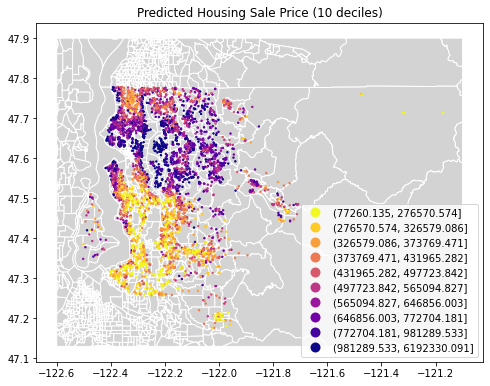

In [34]:
# turning df_output into geo_df_output
df_output['lon'],df_output['lat']=df_output['Longitude']/(10**6),df_output['Latitude']/(10**6)
geometry=[Point(xy) for xy in zip(df_output['lon'],df_output['lat'])]
geo_df_output = gpd.GeoDataFrame(df_output, crs="EPSG:4269",geometry=geometry)
# Visualization: housing prices (10 quantiles)
geo_df_output['Predicted_Sale_qt']=pd.qcut(geo_df_output['predicted_Y'],10)
fig,ax = plt.subplots(figsize =(8,8))
WA_clipped.plot(ax=ax, **{'edgecolor':'white', 'facecolor':'lightgrey'})
cm = plt.cm.get_cmap('plasma').reversed()
geo_df_output.plot(ax=ax, markersize=2, column='Predicted_Sale_qt',cmap=cm,legend=True)
plt.title('Predicted Housing Sale Price (10 deciles)')
plt.savefig('Predicted-SaleDollarCnt-10qt.png')